In [2]:
#Load Kaggle Credentials
import json
import base64

lakehouse = "walmart_forecast_lakehouse_1"

with open(f"/lakehouse/default/Files/kaggle.json") as f:
    kaggle_token = json.load(f)

username = kaggle_token["username"]
key = kaggle_token["key"]

# Kaggle requires Base64-encoded credentials
auth = base64.b64encode(f"{username}:{key}".encode()).decode()
headers = {"Authorization": f"Basic {auth}"}


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 4, Finished, Available, Finished)

In [ ]:
df = spark.sql("SELECT * FROM walmart_forecast_lakehouse_1.dbo.clean_m5_data LIMIT 1000")
display(df)

In [3]:
#Download Data from Kaggle

import requests

url = "https://www.kaggle.com/api/v1/competitions/data/download-all/m5-forecasting-accuracy"
output_path = f"/lakehouse/default/Files/m5.zip"

response = requests.get(url, headers=headers)

with open(output_path, "wb") as f:
    f.write(response.content)

print("Downloaded m5.zip to Lakehouse Files")


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 5, Finished, Available, Finished)

Downloaded m5.zip to Lakehouse Files


In [4]:
#Unzip Dataset

import zipfile
import os

zip_path = f"/lakehouse/default/Files/m5.zip"
extract_path = f"/lakehouse/default/Files/m5/"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped into:", extract_path)


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 6, Finished, Available, Finished)

Unzipped into: /lakehouse/default/Files/m5/


In [5]:
#Load CSVs into Spark

sales = spark.read.csv("abfss://f5b4e086-488c-4ffe-83da-5465acdb9568@onelake.dfs.fabric.microsoft.com/5103d43b-5592-460d-8c40-20136a47c96c/Files/m5/sales_train_validation.csv", header=True, inferSchema=True)
calendar = spark.read.csv("abfss://f5b4e086-488c-4ffe-83da-5465acdb9568@onelake.dfs.fabric.microsoft.com/5103d43b-5592-460d-8c40-20136a47c96c/Files/m5/calendar.csv", header=True, inferSchema=True)
prices = spark.read.csv("abfss://f5b4e086-488c-4ffe-83da-5465acdb9568@onelake.dfs.fabric.microsoft.com/5103d43b-5592-460d-8c40-20136a47c96c/Files/m5/sell_prices.csv", header=True, inferSchema=True)




StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 7, Finished, Available, Finished)

In [6]:
#Save Raw Data as Delta Tables

sales.write.format("delta").mode("overwrite").saveAsTable("raw_sales")
calendar.write.format("delta").mode("overwrite").saveAsTable("raw_calendar")
prices.write.format("delta").mode("overwrite").saveAsTable("raw_prices")


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 8, Finished, Available, Finished)

In [7]:
#load delta from spark

sales = spark.table("raw_sales")
calendar = spark.table("raw_calendar")
prices = spark.table("raw_prices")


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 9, Finished, Available, Finished)

In [8]:
from pyspark.sql.functions import expr

columns = [f"d_{i}" for i in range(1, 1914)]
expr_str = ", ".join([f"'{c}', {c}" for c in columns])

sales_long = sales.selectExpr(
    "id", "item_id", "dept_id", "cat_id", "store_id", "state_id",
    f"stack({len(columns)}, {expr_str}) as (d, sales)"
)


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 10, Finished, Available, Finished)

In [9]:
#Cleaning

df = (
    sales_long
    .join(calendar, "d", "left")
    .join(prices, ["store_id", "item_id", "wm_yr_wk"], "left")
)


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 11, Finished, Available, Finished)

In [10]:

import pyspark.sql.functions as F

df_clean = df.filter("sales IS NOT NULL AND date IS NOT NULL")
df_clean = df_clean.fillna({"sell_price": 0})


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 12, Finished, Available, Finished)

In [11]:
# Creates a time-ordered window per product
# Generates lag features (7 & 28 days)
# Computes rolling averages (7 & 28 days)
# Enriches the dataset with temporal patterns crucial for forecasting

from pyspark.sql.window import Window

w = Window.partitionBy("id").orderBy("date")

df_clean = df_clean.withColumn("lag_7", F.lag("sales", 7).over(w))
df_clean = df_clean.withColumn("lag_28", F.lag("sales", 28).over(w))
df_clean = df_clean.withColumn("rolling_mean_7", 
                               F.avg("sales").over(w.rowsBetween(-7, -1)))
df_clean = df_clean.withColumn("rolling_mean_28", 
                               F.avg("sales").over(w.rowsBetween(-28, -1)))


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 13, Finished, Available, Finished)

In [12]:
df_clean.write.format("delta").mode("overwrite").saveAsTable("clean_m5_data")


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 14, Finished, Available, Finished)

In [1]:

%%sql
SELECT 
    cat_id,
    SUM(sales) AS total_sales
FROM clean_m5_data
GROUP BY cat_id
ORDER BY total_sales DESC;


StatementMeta(, 18cb2fb2-b41f-4547-994b-e834e7e7dd31, 2, Finished, Available, Finished)

<Spark SQL result set with 3 rows and 2 fields>

In [14]:
%%sql
SELECT 
    store_id,
    WEEKOFYEAR(date) AS week,
    AVG(sales) AS avg_weekly_sales
FROM clean_m5_data
GROUP BY store_id, WEEKOFYEAR(date)
ORDER BY store_id, week;


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 16, Finished, Available, Finished)

<Spark SQL result set with 530 rows and 3 fields>

In [15]:
df = spark.table("clean_m5_data")
df.printSchema()
df.show(10)


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 17, Finished, Available, Finished)

root
 |-- store_id: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- wm_yr_wk: integer (nullable = true)
 |-- d: string (nullable = true)
 |-- id: string (nullable = true)
 |-- dept_id: string (nullable = true)
 |-- cat_id: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- sales: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- weekday: string (nullable = true)
 |-- wday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- event_name_1: string (nullable = true)
 |-- event_type_1: string (nullable = true)
 |-- event_name_2: string (nullable = true)
 |-- event_type_2: string (nullable = true)
 |-- snap_CA: integer (nullable = true)
 |-- snap_TX: integer (nullable = true)
 |-- snap_WI: integer (nullable = true)
 |-- sell_price: double (nullable = true)
 |-- lag_7: integer (nullable = true)
 |-- lag_28: integer (nullable = true)
 |-- rolling_mean_7: double (nullable = true)
 |-- ro

In [16]:
df.describe("sales", "sell_price").show()


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 18, Finished, Available, Finished)

+-------+------------------+------------------+
|summary|             sales|        sell_price|
+-------+------------------+------------------+
|  count|          58327370|          58327370|
|   mean| 1.126322153733316| 3.478561538006781|
| stddev|3.8731084464719507|3.5178705484670907|
|    min|                 0|               0.0|
|    max|               763|            107.32|
+-------+------------------+------------------+



In [17]:
import pyspark.sql.functions as F

daily_sales = df.groupBy("date").agg(F.sum("sales").alias("total_sales"))
daily_sales.orderBy("date").show(30)


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 19, Finished, Available, Finished)

+----------+-----------+
|      date|total_sales|
+----------+-----------+
|2011-01-29|      32631|
|2011-01-30|      31749|
|2011-01-31|      23783|
|2011-02-01|      25412|
|2011-02-02|      19146|
|2011-02-03|      29211|
|2011-02-04|      28010|
|2011-02-05|      37932|
|2011-02-06|      32736|
|2011-02-07|      25572|
|2011-02-08|      23071|
|2011-02-09|      23658|
|2011-02-10|      23756|
|2011-02-11|      26445|
|2011-02-12|      34833|
|2011-02-13|      36380|
|2011-02-14|      21804|
|2011-02-15|      24070|
|2011-02-16|      21443|
|2011-02-17|      20318|
|2011-02-18|      23721|
|2011-02-19|      31689|
|2011-02-20|      29283|
|2011-02-21|      23966|
|2011-02-22|      20501|
|2011-02-23|      20757|
|2011-02-24|      20277|
|2011-02-25|      22529|
|2011-02-26|      29908|
|2011-02-27|      28707|
+----------+-----------+
only showing top 30 rows



In [18]:
#Basic Spark ML Linear Regression Model

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

assembler = VectorAssembler(
    inputCols=["lag_7", "lag_28", "rolling_mean_7", "rolling_mean_28", "sell_price"],
    outputCol="features"
)

train_ml = assembler.transform(df.filter("lag_28 IS NOT NULL")).select("features", "sales")

model = LinearRegression(labelCol="sales").fit(train_ml)

print("Model trained successfully!")


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 20, Finished, Available, Finished)

Model trained successfully!


In [23]:


df = spark.table("clean_m5_data")

# Optional: filter for a single store to start (speeds things up)

df = df.filter("store_id = 'CA_1'")
pdf = df.toPandas()
pdf["date"] = pd.to_datetime(pdf["date"])

print(pdf.shape)


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 25, Finished, Available, Finished)

(5832737, 26)


In [24]:
import pandas as pd

train = pdf[pdf["date"] < "2016-04-01"]
test  = pdf[pdf["date"] >= "2016-04-01"]

print(train.shape, test.shape)


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 26, Finished, Available, Finished)

(5759561, 26) (73176, 26)


In [25]:
# Test and validation

FEATURES = [
    "lag_7", "lag_28",
    "rolling_mean_7", "rolling_mean_28",
    "sell_price"
]

TARGET = "sales"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 27, Finished, Available, Finished)

In [26]:
#Train LightGBM Model

import lightgbm as lgb

dtrain = lgb.Dataset(X_train, label=y_train)

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "subsample": 0.8,
}

model = lgb.train(params, dtrain, num_boost_round=500)

print("Model trained!")


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 28, Finished, Available, Finished)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.208379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 5759561, number of used features: 5
[LightGBM] [Info] Start training from score 1.317005


Model trained!


In [27]:
#Forecast Future Sales

preds = model.predict(X_test)
test["prediction"] = preds


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 29, Finished, Available, Finished)

/tmp/ipykernel_6329/1574671543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction"] = preds


In [28]:
#Evaluate Model Accuracy

from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test["sales"], test["prediction"]))
print("RMSE:", rmse)

#M5 winners get RMSE around 2–3, baseline models ~ 7–10.

StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 30, Finished, Available, Finished)

RMSE: 2.0851913289677007


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 31, Finished, Available, Finished)

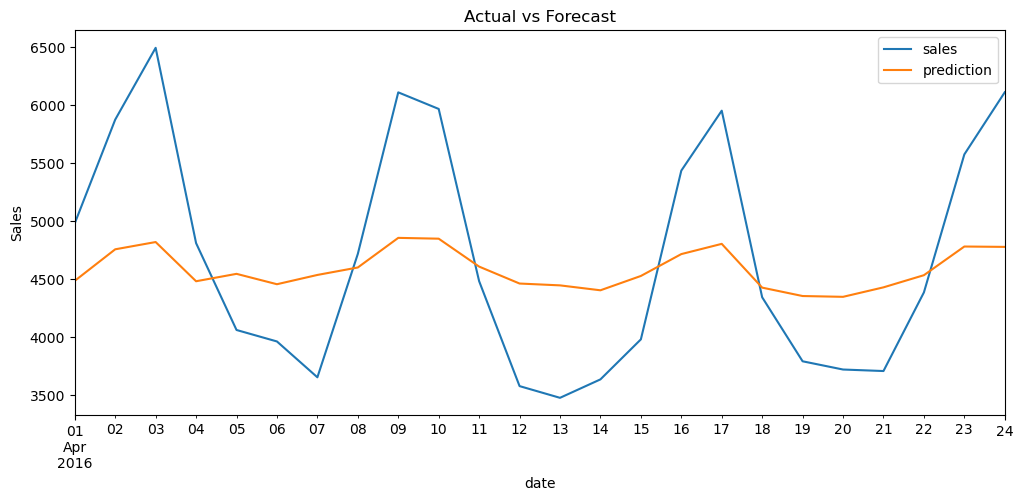

In [29]:
#Plot Actual vs Forecast

import matplotlib.pyplot as plt

subset = test.groupby("date")[["sales", "prediction"]].sum()

subset.plot(figsize=(12,5))
plt.title("Actual vs Forecast")
plt.ylabel("Sales")
plt.show()


In [30]:
model = LinearRegression(labelCol="sales").fit(train_ml)


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 32, Finished, Available, Finished)

In [31]:
#Generate Predictions Using Your Model

predictions = model.transform(
    assembler.transform(
        df.filter("lag_28 IS NOT NULL")
    )
)


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 33, Finished, Available, Finished)

In [32]:
forecast_df = predictions.select(
    "id",
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "date",
    F.col("sales").alias("actual_sales"),
    F.col("prediction").alias("forecast_sales")
)


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 34, Finished, Available, Finished)

In [33]:
forecast_df.write.format("delta").mode("overwrite").saveAsTable("forecast_results")


StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 35, Finished, Available, Finished)

In [34]:
%%sql
SELECT * FROM forecast_results LIMIT 20;



StatementMeta(, 48220ef9-ea0f-4724-825f-b719f6f472dd, 36, Finished, Available, Finished)

<Spark SQL result set with 20 rows and 9 fields>